In [1]:
import math
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider
from tqdm import tqdm

## Load data

In [2]:
experiment = "split_20231212"
data = "FWF006"
cell_type = "Proximal"

In [3]:
def open_df(data,experiment=experiment):
    df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
    df = df[3:]
    df = df.astype({
            "ID" : int,
            "TRACK_ID" : int, 
            "POSITION_X" : float,
            "POSITION_Y" : float,
            "POSITION_Z" : float,
            "POSITION_T" : float,
            "FRAME" : int,
            "MIN_INTENSITY_CH1" : float,
            "MAX_INTENSITY_CH1" : float,
            "MEDIAN_INTENSITY_CH1" : float,
            "TOTAL_INTENSITY_CH1" : float,
            "STD_INTENSITY_CH1" : float,
            "CONTRAST_CH1" : float,
            "SNR_CH1" : float
            })
    return df

In [4]:
def get_filtered_ids_len(df,N=100):
    ids, len_ids = np.unique(df["TRACK_ID"].to_numpy(),return_counts=True)
    keep = np.ones(len(ids),dtype=bool)
    for i in range(len(ids)):
        keep[i] = (len_ids[i]>=N) and (len(np.unique(df[df["TRACK_ID"]==ids[i]]["FRAME"].to_numpy()))>=N)
    return ids[keep], len_ids[keep]

def traj(id,df): 
    # frames = np.sort(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    frames = np.unique(df[df["TRACK_ID"]==id]["FRAME"].to_numpy())
    T = len(frames)
    pos = np.zeros((T,3))
    intensity = np.zeros(T)
    df_id = df[df["TRACK_ID"]==id]
    for t in range(T):
        pos[t,0] = df_id[df_id["FRAME"]==frames[t]]["POSITION_X"].values[0]
        pos[t,1] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Y"].values[0]
        pos[t,2] = df_id[df_id["FRAME"]==frames[t]]["POSITION_Z"].values[0]
        intensity[t] = df_id[df_id["FRAME"]==frames[t]]["TOTAL_INTENSITY_CH1"].values[0]
    return frames, pos, intensity

def df_to_traj(data,N=100):
    df = open_df(data)
    ids, len_ids = get_filtered_ids_len(df,N=N)
    trajs = []
    for id in tqdm(ids):
        trajs.append(traj(id,df))
    return trajs
    

In [5]:
trajs = df_to_traj(data + "_" + cell_type, N=100)

if cell_type == "Proximal":
    cmap = plt.cm.Purples(np.linspace(0.3,1,len(trajs)))
elif cell_type=="Distal":
    cmap = plt.cm.Greens(np.linspace(0.3,1,len(trajs)))
else:
    cmap = plt.cm.Blue(np.linspace(0.3,1,len(trajs)))

/var/folders/q_/7gz310cd4n1_v1xcnv2_qdbm0000gn/T/ipykernel_15525/1093890562.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(experiment + "/Automation_out/"+data+"_spots.csv",encoding='cp1252')
100%|██████████| 192/192 [00:25<00:00,  7.65it/s]


## Plot trajectory

### One individual trajectory

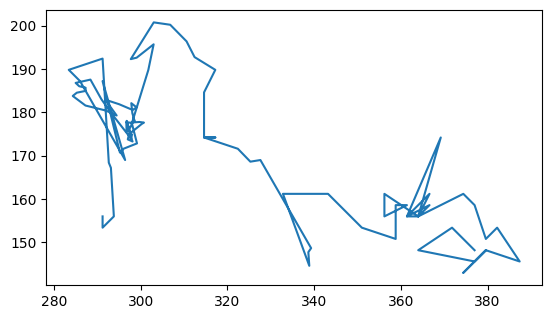

In [6]:
%matplotlib inline

fig, ax = plt.subplots()
n = 2
log_intensity = np.log10(trajs[n][2])
log_intensity -= log_intensity.min()
log_intensity *= 0.9/log_intensity.max()
log_intensity += 0.09
# ax.scatter(trajs_P[n][1][:,0],trajs_P[n][1][:,1],alpha=log_intensity)
ax.plot(trajs[n][1][:,0],trajs[n][1][:,1])
# ax.set_xlim(0,1300)
# ax.set_ylim(0,1300)
ax.set_aspect("equal")

### All trajectories

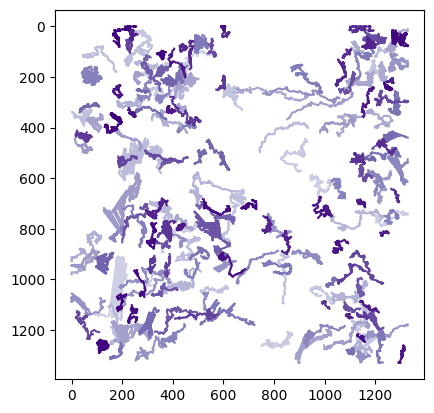

In [7]:
%matplotlib inline

fig2d = plt.figure()
ax2d = fig2d.add_subplot()

clen = len(cmap)
cind = 0
for tr in trajs:
    # ax2d.plot(tr[1][:,0],tr[1][:,1],'.',markersize=0.7,color=colors[cind%clen,:])
    ax2d.plot(tr[1][:,0],tr[1][:,1],color=cmap[cind%clen,:])
    cind += 1
ax2d.set_aspect("equal")
ax2d.invert_yaxis()

### Trajectories over time

In [8]:
def big_table_frame(trajs):
    N = len(trajs)
    T = max([max(traj[0]) for traj in trajs])
    big_table = -np.ones((T+1,N,3))
    for n in range(N):
        big_table[trajs[n][0],n,0] = trajs[n][1][:,0]
        big_table[trajs[n][0],n,1] = trajs[n][1][:,1]
        log_intensity = np.log10(trajs[n][2])
        log_intensity -= log_intensity.min()
        log_intensity *= 0.9/log_intensity.max()
        log_intensity += 0.09
        big_table[trajs[n][0],n,2] = log_intensity
    return big_table 

def plot_traj_frame(big_table,T=1,cmap=cmap):
    
    N = big_table.shape[1]
    fig = plt.figure()
    ax = fig.add_subplot()
    clen = len(cmap)
    cind = 0
    trajs_pl = []
    for n in range(N):
        trajs_pl.append(ax.plot(big_table[:(T+1),n,0],big_table[:(T+1),n,1],'.',markersize=2,color=cmap[cind%clen,:])[0])
        cind += 1
    scat_point = ax.scatter(big_table[T,:,0],big_table[T,:,1],s=12,c='r',zorder=2)
    ax.set_xlim(0,1300)
    ax.set_ylim(0,1300)
    ax.set_aspect("equal")
    ax.invert_yaxis()
    
    fig.subplots_adjust(left=0.25, bottom=0.25)

    axtime = fig.add_axes([0.25, 0.1, 0.65, 0.03])
    frame_slider = Slider(
        ax=axtime,
        label='FRAME',
        valmin=1,
        valmax=big_table.shape[0]-1,
        valinit=1,
        valstep=1
    )
    
    def update(val):
        scat_point.set_offsets(np.c_[big_table[frame_slider.val,:,0],big_table[frame_slider.val,:,1]])
        for n in range(N):
            trajs_pl[n].set_xdata(big_table[:(frame_slider.val+1),n,0])
            trajs_pl[n].set_ydata(big_table[:(frame_slider.val+1),n,1])
            trajs_pl[n].set_alpha(float(big_table[frame_slider.val,n,0]>=0))
        fig.canvas.draw_idle()
    
    
    frame_slider.on_changed(update)
    
    return fig

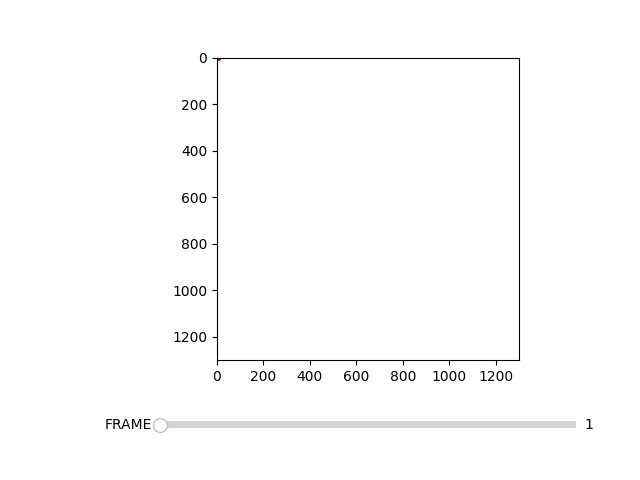

In [19]:
%matplotlib widget

fig_traj_time = plot_traj_frame(big_table_frame(trajs))

## Mean-square displacement

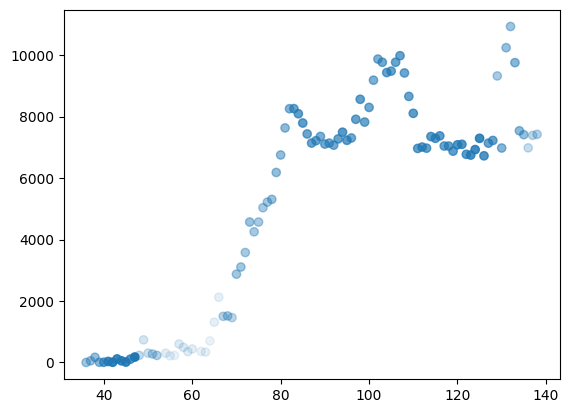

In [21]:
def SD(traj):
    frames = traj[0]
    pos = traj[1]
    T = len(frames)
    X0 = pos[0,:]
    return ((X0 - pos[:,:])**2).sum(1)

%matplotlib inline

fig, ax = plt.subplots()
ax.scatter(trajs[n][0],SD(trajs[n]),alpha=log_intensity)

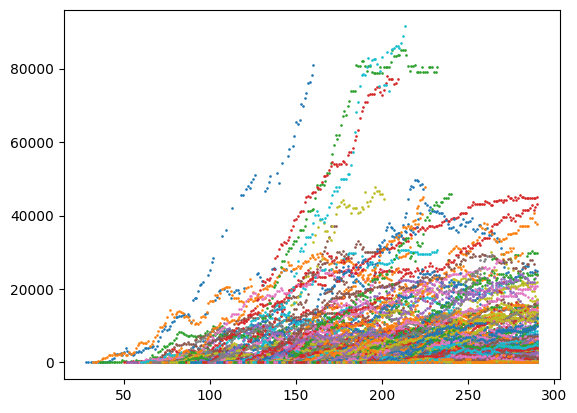

In [22]:
%matplotlib inline

fig, ax = plt.subplots()
sd_f = []
for traj in trajs[0:]:
    ax.scatter(traj[0],SD(traj),s=0.8)
    sd_f.append(SD(traj)[99])
# ax.plot(sd_f,'.')

## Speed and directions

In [12]:
def speed_dir(traj,dt):
    frames = traj[0]
    pos = traj[1]
    speed = []
    direct = []
    t = 0 
    while t+dt<len(frames): 
        speed.append(np.linalg.norm(pos[t+dt,:-1] - pos[t,:-1])/(frames[t+dt] - frames[t]))
        direct.append(np.arctan2(pos[t+dt,1] - pos[t,1],pos[t+dt,0] - pos[t,0]))
        t += dt
    return np.array(speed), np.array(direct)

In [13]:
speed, direct = speed_dir(trajs[0],5)

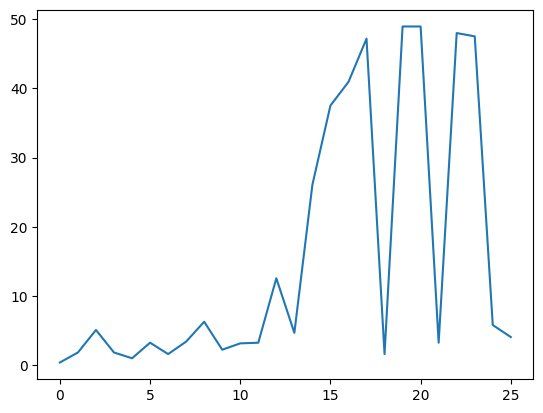

In [14]:
%matplotlib inline
plt.plot(speed)

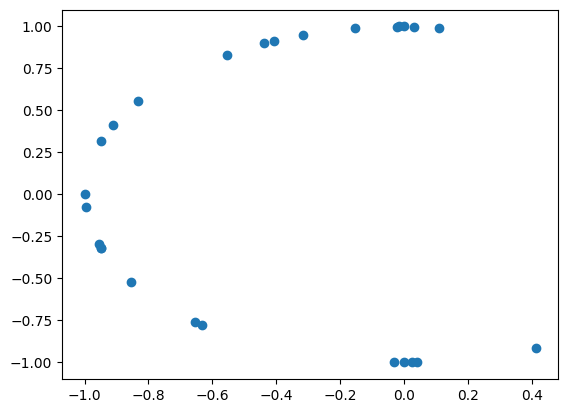

In [15]:
%matplotlib inline
plt.scatter(np.cos(direct),np.sin(direct))


(0.0, 1.0)

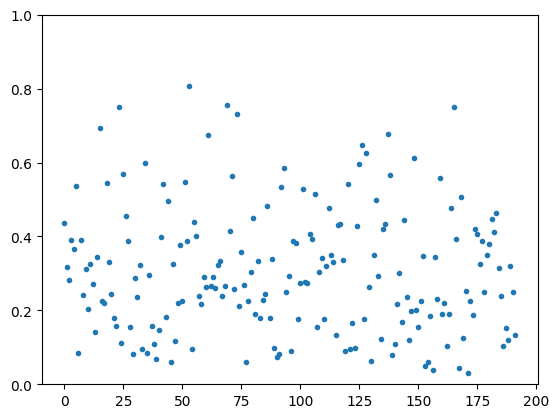

In [16]:
%matplotlib inline
kappa = []
leng = []
for traj in trajs:
    speed, direct = speed_dir(traj,5)
    # print(len(direct))
    leng.append(len(direct))
    kappa.append(np.linalg.norm(np.mean(np.c_[np.cos(direct),np.sin(direct)],axis=0)))
    
plt.plot(kappa,'.')
plt.ylim(0,1)
# plt.plot(leng,kappa,'.')